#HW4 Questions:

A) 11.2 - Binding data

B) 12.4 - Novick & Weiner

C) 12.8 - SIR model time course

D) 13.6 - Endemic SIRS model fixed point


In [ ]:
# import os
# import copy
# from pathlib import Path
# from numbers import Number
# from collections import namedtuple
# from typing import NamedTuple, List, Callable, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
import seaborn as sns

from scipy.optimize import least_squares
# from matplotlib import rc
# from IPython.display import HTML
# plt.matplotlib.rcParams['animation.embed_limit'] = 2**128

# from scipy.special import factorial
# from google.colab import drive

# rng = np.random.default_rng()


# Q11.2 - Binding data



### Obtaining dataset 18 - hemoglobin file and plotting it


In [ ]:
hg = pd.DataFrame(np.load(np.DataSource().open('http://www.physics.upenn.edu/biophys/PMLS2e/Datasets/HbMb/hemoglobin.npy', "rb")), columns=('concentration', 'p_unbound'))
hg.sort_values('p_unbound', inplace=True)
hg.reset_index(drop=True, inplace=True)
hg[:5]

,concentration,p_unbound
0,0.000027,0.0298
1,0.000024,0.0302
2,0.000026,0.0327
3,0.000025,0.0329
4,0.000023,0.0416


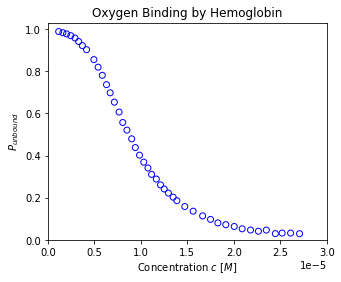

In [ ]:
xmax = 3e-5
ymax = 1.03

plt.subplots(figsize=(5,4))
plt.scatter(hg.concentration, hg.p_unbound, facecolors='none', edgecolors='b')

plt.xlim(0, xmax)
plt.xlabel('Concentration $c$ [$M$]')

plt.ylim(0, ymax)
plt.ylabel('$P_{unbound}$')

plt.title('Oxygen Binding by Hemoglobin')
plt.show()

### a) Suggesting good approximate values for $K_d$ and $n$

To suggest a good numerical value for $K_d$, we can look at the concentration where half of the molecules are bound. To do that I'll take the average of the two concentrations

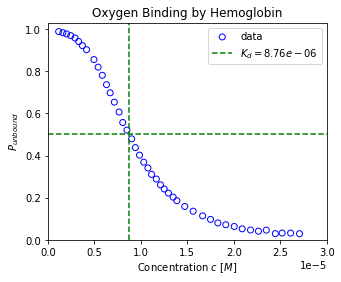

In [ ]:
index_prob_half = hg.p_unbound.searchsorted(0.5)
k_d = (hg.concentration[index_prob_half - 1] + hg.concentration[index_prob_half]) / 2

plt.subplots(figsize=(5,4))
plt.scatter(hg.concentration, hg.p_unbound, facecolors='none', edgecolors='b', label='data')

plt.plot(np.ones(20) * k_d, np.linspace(0, ymax, 20), 'g--', label=f'$K_d = {k_d: .2e}$')
plt.plot(np.linspace(0, xmax, 20), np.ones(20) * 0.5, 'g--')

plt.xlim(0, xmax)
plt.xlabel('Concentration $c$ [$M$]')

plt.ylim(0, ymax)
plt.ylabel('$P_{unbound}$')

plt.legend()
plt.title('Oxygen Binding by Hemoglobin')
plt.show()


To get the estimator for $n$, we will first transform the concentration to a dimensionless variable $\bar{c}$

In [ ]:
hg['c_hat'] = hg.concentration / k_d
hg[:5]

,concentration,p_unbound,c_hat
0,0.000027,0.0298,3.090452
1,0.000024,0.0302,2.793513
2,0.000026,0.0327,2.980813
3,0.000025,0.0329,2.876884
4,0.000023,0.0416,2.585656


For $\bar{c} >> 1$, the probability $P_{unbound} = (1 + \bar{c}^n)^{-1} ≈ \bar{c}^{-n}$, an we can extract the slope of the log-log graph as an approximation of n:

In [ ]:
high_c = hg.c_hat > 2
cov_log_data = np.cov(np.log(hg.c_hat)[high_c], np.log(hg.p_unbound)[high_c])
slope = -cov_log_data[0, 1] / cov_log_data[0, 0]  # linear regression b=cov(x,y)/var(x)

print(f'n is approx {slope: .2f}')

n is approx  2.66


Plotting the graph with these values we get:

In [ ]:
def calc_p_unbound(x, k_d, n):
    return (1 + (np.array(x) / k_d)**n)**(-1)

calc_p_unbound(1., 1, 1)

0.5

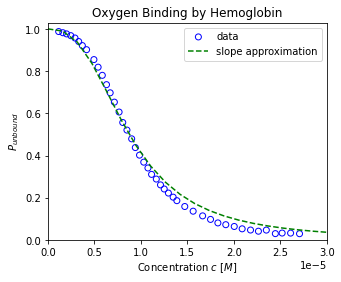

In [ ]:
grid = np.linspace(0, xmax, 20)

plt.subplots(figsize=(5,4))
plt.scatter(hg.concentration, hg.p_unbound, facecolors='none', edgecolors='b', label='data')
plt.plot(grid, calc_p_unbound(grid, k_d, slope), 'g--', label='slope approximation')

plt.xlim(0, xmax)
plt.xlabel('Concentration $c$ [$M$]')

plt.ylim(0, ymax)
plt.ylabel('$P_{unbound}$')

plt.title('Oxygen Binding by Hemoglobin')
plt.legend()

plt.show()

Before moving to regression, we can improve our estimation by developing relation $P_{unbound} = (1 + \bar{c}^n)^{-1}$ to extract $n$:

$$
P_{unbound} (1 + \bar{c}^n) = 1
\\
P_{unbound} \cdot \bar{c}^n = 1 - P_{unbound}
\\
log(P_{unbound} \cdot \bar{c}^n) = log(1 - P_{unbound})
\\
n = \frac{log(1 - P_{unbound}) - log(P_{unbound})}{log(\bar{c})}
$$

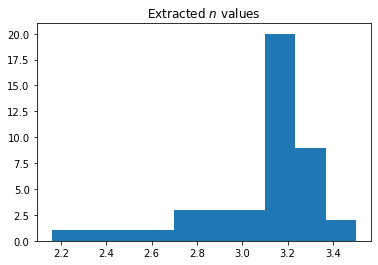

In [ ]:
ns = (np.log(1 - hg.p_unbound) - np.log(hg.p_unbound)) / np.log(hg.c_hat)
plt.hist(ns)
plt.title('Extracted $n$ values')
plt.show()

And plotting with an median of the calculated n:

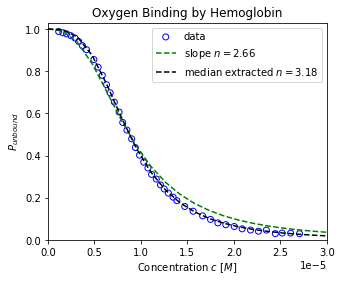

In [ ]:
grid = np.linspace(0, xmax, 20)

plt.subplots(figsize=(5,4))
plt.scatter(hg.concentration, hg.p_unbound, facecolors='none', edgecolors='b', label='data')
plt.plot(grid, calc_p_unbound(grid, k_d, slope), 'g--', label=f'slope $n={slope: .2f}$')
plt.plot(grid, calc_p_unbound(grid, k_d, ns.median()), 'k--', label=f'median extracted $n={ns.median(): .2f}$')

plt.xlim(0, xmax)
plt.xlabel('Concentration $c$ [$M$]')

plt.ylim(0, ymax)
plt.ylabel('$P_{unbound}$')

plt.title('Oxygen Binding by Hemoglobin')
plt.legend()

plt.show()

### b) least square fitting

For the least square fitting, we will write down the square distance loss and maximize it.
$$
R^2 = \sum_i (P_i - (1 + (\frac{c_i}{K_d})^n)^{-1})^2
\\
$$



In [ ]:
def loss(param):
    return hg.p_unbound - (1. + (hg.concentration / param[0])**param[1])**-1.

param_0 = np.array([k_d, slope])
print(f'k_d={k_d: .2e}, slope={slope: .2f}, n_median={ns.median(): .2f}')
print(f'loss by slope = {np.sum(loss(param_0)**2): .2e}')
print(f'loss by median n = {np.sum(loss((k_d, ns.median()))**2): .2e}')


k_d= 8.76e-06, slope= 2.66, n_median= 3.18
loss by slope =  3.58e-02
loss by median n =  2.28e-03


In [ ]:
res_1 = least_squares(loss, (k_d, slope), bounds=([0, 1], np.inf))
print(f'loss after optimization: {np.sum(loss(res_1.x)**2): .2e}')


loss after optimization:  1.81e-03


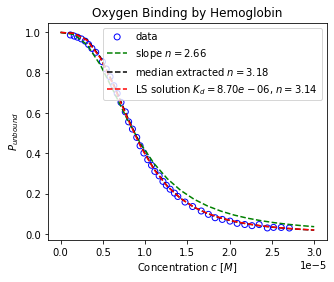

In [ ]:
k_d_ls, n_ls = res_1.x

grid = np.linspace(0, xmax, 20)

plt.subplots(figsize=(5,4))
plt.scatter(hg.concentration, hg.p_unbound, facecolors='none', edgecolors='b', label='data')
plt.plot(grid, calc_p_unbound(grid, k_d, slope), 'g--', label=f'slope $n={slope: .2f}$')
plt.plot(grid, calc_p_unbound(grid, k_d, ns.median()), 'k--', label=f'median extracted $n={ns.median(): .2f}$')
plt.plot(grid, calc_p_unbound(grid, k_d_ls, n_ls), 'r--', label=f'LS solution $K_d={k_d_ls: .2e}$, $n={n_ls: .2f}$')

# plt.xlim(0, xmax)
plt.xlabel('Concentration $c$ [$M$]')

# plt.ylim(0, ymax)
plt.ylabel('$P_{unbound}$')

plt.title('Oxygen Binding by Hemoglobin')
plt.legend()

plt.show()

# Q12.4 Novick-Weiner data


### Obtaining the data
Two datasets - high (`nwh`) and moderate (`nwm`) inducer levels

In [ ]:
url_files = 'http://www.physics.upenn.edu/biophys/PMLS2e/Datasets/Novick/g149novick{}.txt'
nwh = pd.read_csv(url_files.format('A'), header=None, names=('time', 'fraction'))
nwm = pd.read_csv(url_files.format('B'), header=None, names=('time', 'fraction'))

print('high inducer level data')
nwh.T


high inducer level data


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
time,0.1699,0.4426,0.5111,0.7156,1.0564,1.2041,1.4311,1.6465,1.8283,2.1119,2.4182,2.9970,3.6763,4.2308,4.8316,5.4070,6.0646,6.6638
fraction,0.0190,0.0855,0.1164,0.1639,0.2470,0.2803,0.3278,0.3563,0.4038,0.4537,0.5059,0.6152,0.6746,0.7126,0.7981,0.7601,0.8599,0.8741


### a) high induction level data

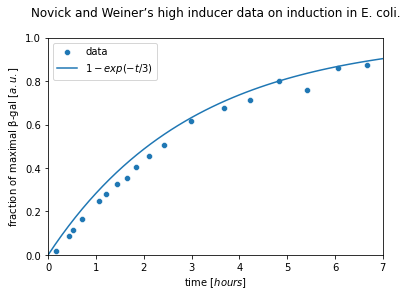

In [ ]:
max_t = 7
tau_guess = 3

grid = np.linspace(0, max_t, 50)

g = sns.scatterplot(x='time', y='fraction', data=nwh, label='data')
sns.lineplot(x=grid, y=(1 - np.exp(-grid / tau_guess)), label=r'$1 - exp(-t / 3)$')

g.set(xlim=(0, max_t), ylim=(0, 1),
      xlabel='time $[hours]$', ylabel='fraction of maximal β-gal $[a.u.]$',
      title='Novick and Weiner’s high inducer data on induction in E. coli.\n')

plt.show()

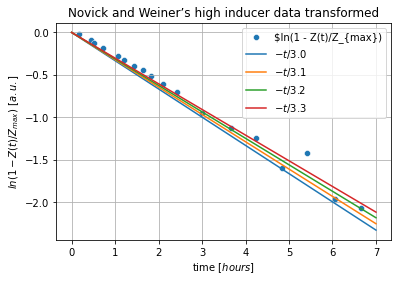

In [ ]:
nwh['ln_1_minus_frac'] = np.log(1 - nwh.fraction)

g = sns.scatterplot(x='time', y='ln_1_minus_frac', data=nwh, label='$ln(1 - Z(t)/Z_{max})')
for guess in [3.0, 3.1, 3.2, 3.3]:
  sns.lineplot(x=grid, y=(-grid / guess), label=fr'$-t / {guess}$')

g.set(xlabel='time $[hours]$', ylabel='$ln(1 - Z(t)/Z_{max})\ [a.u.]$',
      title='Novick and Weiner’s high inducer data transformed')

plt.grid()
plt.show()


### b) moderate induction level data
my first guess for $z_0$ will be the mean of the fraction

In [ ]:
print('moderate inducer level data')
nwm.T

moderate inducer level data


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
time,0.076800,1.061400,1.566900,2.072100,2.37570,2.72970,3.0585,3.56400,4.05780,4.53870,5.04510,5.51340,6.50130,7.50210,8.5047,9.6681,10.8207,12.0003,13.1667,14.091
fraction,0.000501,0.000595,0.000714,0.000856,0.00102,0.00121,0.0015,0.00174,0.00257,0.00312,0.00379,0.00448,0.00603,0.00782,0.0105,0.0116,0.0133,0.0162,0.0188,0.020


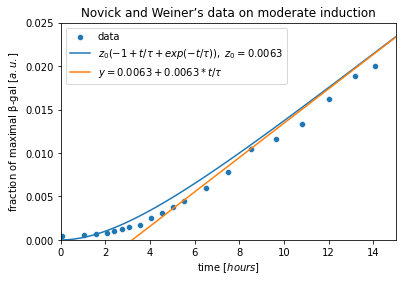

In [ ]:
max_t = 15
tau_guess = 3.2
z0_guess = nwm.fraction.mean()

grid = np.linspace(0, max_t, 50)

g = sns.scatterplot(x='time', y='fraction', data=nwm, label='data')
sns.lineplot(x=grid,
             y=(z0_guess * (-1 + (grid / tau_guess) + np.exp(-grid / tau_guess))),
             label=r'$z_0(-1 + t / \tau + exp(-t / \tau)),\ z_0 = %.4f$' % z0_guess)

sns.lineplot(x=grid, y=(-z0_guess + z0_guess * grid / tau_guess),
             label=fr'$y={z0_guess: .4f} + {z0_guess: .4f} * t / \tau$')

g.set(xlim=(0, max_t), ylim=(0, 0.025),
      xlabel='time $[hours]$', ylabel='fraction of maximal β-gal $[a.u.]$',
      title='Novick and Weiner’s data on moderate induction')

plt.legend()
plt.show()

Improving the result using fitting of the data in $10 \leq t \leq 15$.

We expect the fraction there to be equal approximately to $-z_0 + z_0 * t / \tau$

In [ ]:
def lin_func(x, tau=3.2):
    indices = (nwm.time >= 10) & (nwm.time <= 15)
    return nwm[indices].fraction - (-x[0] + x[0] * nwm[indices].time / tau)


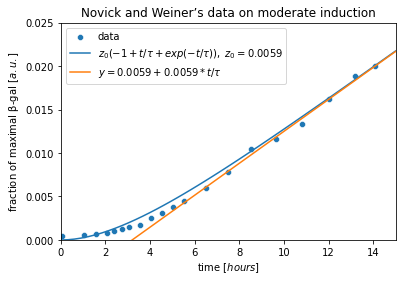

In [ ]:
z0_fit = least_squares(lin_func, z0_guess).x[0]

z0_guess = z0_fit

grid = np.linspace(0, max_t, 50)

g = sns.scatterplot(x='time', y='fraction', data=nwm, label='data')
sns.lineplot(x=grid,
             y=(z0_guess * (-1 + (grid / tau_guess) + np.exp(-grid / tau_guess))),
             label=r'$z_0(-1 + t / \tau + exp(-t / \tau)),\ z_0 = %.4f$' % z0_guess)

sns.lineplot(x=grid, y=(-z0_guess + z0_guess * grid / tau_guess),
             label=fr'$y={z0_guess: .4f} + {z0_guess: .4f} * t / \tau$')

g.set(xlim=(0, max_t), ylim=(0, 0.025),
      xlabel='time $[hours]$', ylabel='fraction of maximal β-gal $[a.u.]$',
      title='Novick and Weiner’s data on moderate induction')

plt.legend()
plt.show()

# Q12.8 - SIR model time course


### a) time course
Equation 12.7 states:
$$ \frac{ds}{d\bar{t}}=-R_0is;\ \frac{di}{d\bar{t}}=(R_0s - 1)i;\ i+s \leq 1$$


Parameter values: $R_0=2.5,\ \gamma=1/(20\ \text{day})$

Initial values: $s(0)=0.99,\ i(0)=0.01$

To evaluate $T=40$ weeks in dimensionless time (scaled by $\gamma$) we will need a total scaled time of $\bar{T} = T * 7 * 1/20 = 14$


In [ ]:
R_knot = 2.5
gamma = 1 / 20  # days
s0, i0 = 0.99, 0.01
T = 40  # weeks
T_bar = 40 * 7 * gamma

dt = 0.05
total_steps = int(T_bar / dt) + 1
t_bar = np.linspace(0, T_bar, total_steps)

def calc_ds_di(s, i):
  return np.array([[-R_knot * i * s, i * (R_knot * s - 1)]])


In [ ]:
time_course = np.zeros((total_steps, 2))
time_course[0] = [s0, i0]

for step in range(1, total_steps):
    s, i = time_course[step - 1]
    time_course[step] =  dt * calc_ds_di(s, i) + [s, i]

results = pd.DataFrame(time_course, columns=['s', 'i'])
results['t_bar'] = t_bar
results['days'] = results['t_bar'] / gamma
results['weeks'] = results['days'] / 7
results

,s,i,t_bar,days,weeks
0,0.990000,0.010000,0.00,0.0,0.000000
1,0.988762,0.010738,0.05,1.0,0.142857
2,0.987435,0.011528,0.10,2.0,0.285714
3,0.986013,0.012374,0.15,3.0,0.428571
4,0.984487,0.013281,0.20,4.0,0.571429
...,...,...,...,...,...
276,0.102758,0.000218,13.80,276.0,39.428571
277,0.102755,0.000209,13.85,277.0,39.571429
278,0.102752,0.000202,13.90,278.0,39.714286
279,0.102750,0.000194,13.95,279.0,39.857143


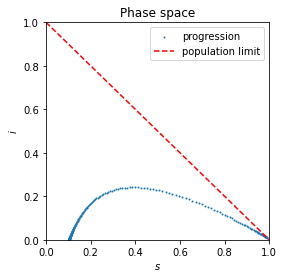

In [ ]:
plt.subplots(figsize=(4, 4))
plt.scatter(results.s, results.i, s=1, label='progression')
plt.plot(np.linspace(0, 1, 20), 1 - np.linspace(0, 1, 20), 'r--', label='population limit')

plt.xlim((0, 1))
plt.xlabel('$s$')
plt.ylim((0, 1))
plt.ylabel('$i$')

plt.title('Phase space')
plt.legend()
plt.show()

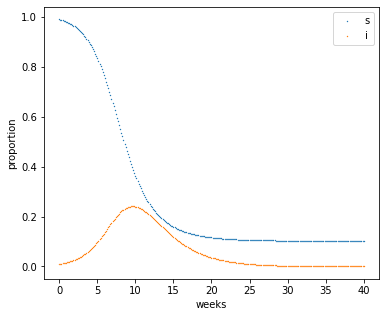

In [ ]:
plt.subplots(figsize=(6, 5))
g = sns.scatterplot(data=results, x='weeks', y='s', s=2, label='s')
sns.scatterplot(data=results, x='weeks', y='i', s=2, label='i')

g.set(ylabel='proportion')
plt.legend()
plt.show()


### b) Estimating $N_{tot}$

We have $2816 = N_{case} = N_{tot} * (1-s(\infty))$

Moving things around we get

In [ ]:
N_tot = int(2816 / (1. - results.s.iat[-1]))
print(f'Number of total population is equal {N_tot}')

Number of total population is equal 3138


### c) plotting new cases
$ -N_{tot} \frac{ds}{dt} = -N_{tot} \frac{ds}{d\bar{t}} \gamma = N_{tot} R_0 s i \gamma $

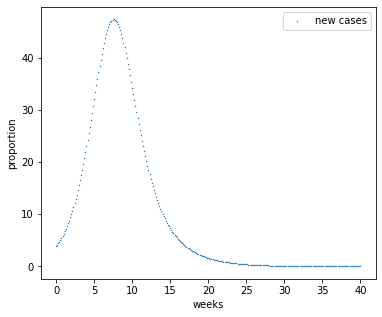

In [ ]:
results['new_cases'] = N_tot * R_knot * results.s * results.i * gamma

plt.subplots(figsize=(6, 5))
g = sns.scatterplot(data=results, x='weeks', y='new_cases', s=2, label='new cases')

g.set(ylabel='proportion')
plt.legend()
plt.show()


# Q13.6 - Endemic SIRS model fixed point

Working with equation 12.8 rescaled for time we get the DE system:
$$
\frac{ds}{d\bar{t}} = -R_0si + \mu (1 - s - i) ;\ \
\frac{di}{d\bar{t}} = (R_0s - 1)i;\ \
i+s \leq 1
$$

Using the parameters: $R_0 = 3,\ \mu=0.07$, we are required to use linear stability to analyse the nontrivial fixed point.

Let us start with calculating the Jacobian matrix:
$$
J(\begin{bmatrix} -R_0si + \mu (1 - s - i) \\ (R_0s - 1)i\end{bmatrix}) =
J(\begin{bmatrix} -3si + 0.07 - 0.07s - 0.07i \\ 3si - i\end{bmatrix}) =
\begin{bmatrix} \frac{d}{ds} -3si + 0.07 - 0.07s - 0.07i & \frac{d}{di} -3si + 0.07 - 0.07s - 0.07i \\ \frac{d}{ds}3si - i & \frac{d}{di}3si - i \end{bmatrix} =
\begin{bmatrix} -3i - 0.07 & -3s - 0.07 \\ 3i & 3s - 1 \end{bmatrix}
$$

The location of the nontrivial point is the intersection of the two nullclines $R_0s = 1$ and $R_0si = \mu (1 - s - i)$. The first equation gives us $s = 1/3$, and the second one:
$$
R_0si = \mu (1 - s - i)
\\
3 \cdot 1/3 \cdot i = 0.07 (1 - 1/3 - i)
\\
i = \frac{0.14}{3.21} = 0.0436
$$

The value of the Jacobianin this point is
$$ J =
\begin{bmatrix} -3 \cdot 0.0436 - 0.07 & -3\cdot 1/3 - 0.07 \\ 3 \cdot 0.0436 & 3\cdot 1/3 - 1 \end{bmatrix} =
\begin{bmatrix} -0.201 & -1.07 \\ 0.131 & 0 \end{bmatrix}
$$
Extracting the eigenvalues:

In [ ]:
R_0 = 3
mu = 0.07
s = 1 / R_0
i = mu * (1 - s) / (1 + mu )

jacobian = np.array([[-3 * i - mu, -3 * s - mu], [3 * i , 3 * s - 1]])
jacobian

array([[-0.20084112, -1.07      ],
       [ 0.13084112,  0.        ]])

In [ ]:
np.linalg.eig(jacobian)[0]

array([-0.10042056+0.36043822j, -0.10042056-0.36043822j])

According to $T_2$ 13.4.1c' Linear Stability Analysis:

*If both \[eigenvalues\] are complex, then the fixed point is called a spiral: unstable in the case of the relaxation oscillator, or stable if both have negative real
part.*

And thus our nontrivial fixed point is a stable spiral!